# Unsupervised Learning: Social media post analyzer

In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Data
the data was get from UC Irvine Machine Learning Repository [Facebook Live Sellers in Thailand](https://archive.ics.uci.edu/dataset/488/facebook+live+sellers+in+thailand). The dataset contains the information of posts of 10 facebook pages of Thai fashion and cosmetics retail sellers. It is composed by 7051 record with 11 features each. 

[1] Dehouche, N. (2018). Facebook Live Sellers in Thailand [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5R60S.

In [146]:
data = pd.read_csv("./data/Live_20210128.csv")

### Exploratory data Analisis (EDA)

In [147]:
data.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,1,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,2,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,3,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,4,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,5,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         7050 non-null   int64  
 1   status_type       7050 non-null   object 
 2   status_published  7050 non-null   object 
 3   num_reactions     7050 non-null   int64  
 4   num_comments      7050 non-null   int64  
 5   num_shares        7050 non-null   int64  
 6   num_likes         7050 non-null   int64  
 7   num_loves         7050 non-null   int64  
 8   num_wows          7050 non-null   int64  
 9   num_hahas         7050 non-null   int64  
 10  num_sads          7050 non-null   int64  
 11  num_angrys        7050 non-null   int64  
 12  Column1           0 non-null      float64
 13  Column2           0 non-null      float64
 14  Column3           0 non-null      float64
 15  Column4           0 non-null      float64
dtypes: float64(4), int64(10), object(2)
memory

In [149]:
data.isna().sum()

status_id              0
status_type            0
status_published       0
num_reactions          0
num_comments           0
num_shares             0
num_likes              0
num_loves              0
num_wows               0
num_hahas              0
num_sads               0
num_angrys             0
Column1             7050
Column2             7050
Column3             7050
Column4             7050
dtype: int64

In [150]:
data = data.drop(["Column1", "Column2", "Column3", "Column4"], axis=1)

In [151]:
data.isna().sum()

status_id           0
status_type         0
status_published    0
num_reactions       0
num_comments        0
num_shares          0
num_likes           0
num_loves           0
num_wows            0
num_hahas           0
num_sads            0
num_angrys          0
dtype: int64

In [152]:
df_train = data.drop(["status_id", "status_published"], axis=1)

In [153]:
df_train["status_type"].unique()

array(['video', 'photo', 'link', 'status'], dtype=object)

In [154]:
s_type = {
    "video": 1,
    "photo": 2,
    "link": 3,
    "status": 4
}

df_train["s_type"] = df_train["status_type"].apply(lambda c : s_type[c])
df_train = df_train.drop(["status_type"], axis=1)

In [155]:
df_train.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,s_type
0,529,512,262,432,92,3,1,1,0,1
1,150,0,0,150,0,0,0,0,0,2
2,227,236,57,204,21,1,1,0,0,1
3,111,0,0,111,0,0,0,0,0,2
4,213,0,0,204,9,0,0,0,0,2


In [156]:
features = ["num_reactions", "num_comments", "num_shares", "num_loves", "num_wows", "num_sads", "num_angrys"]


[]

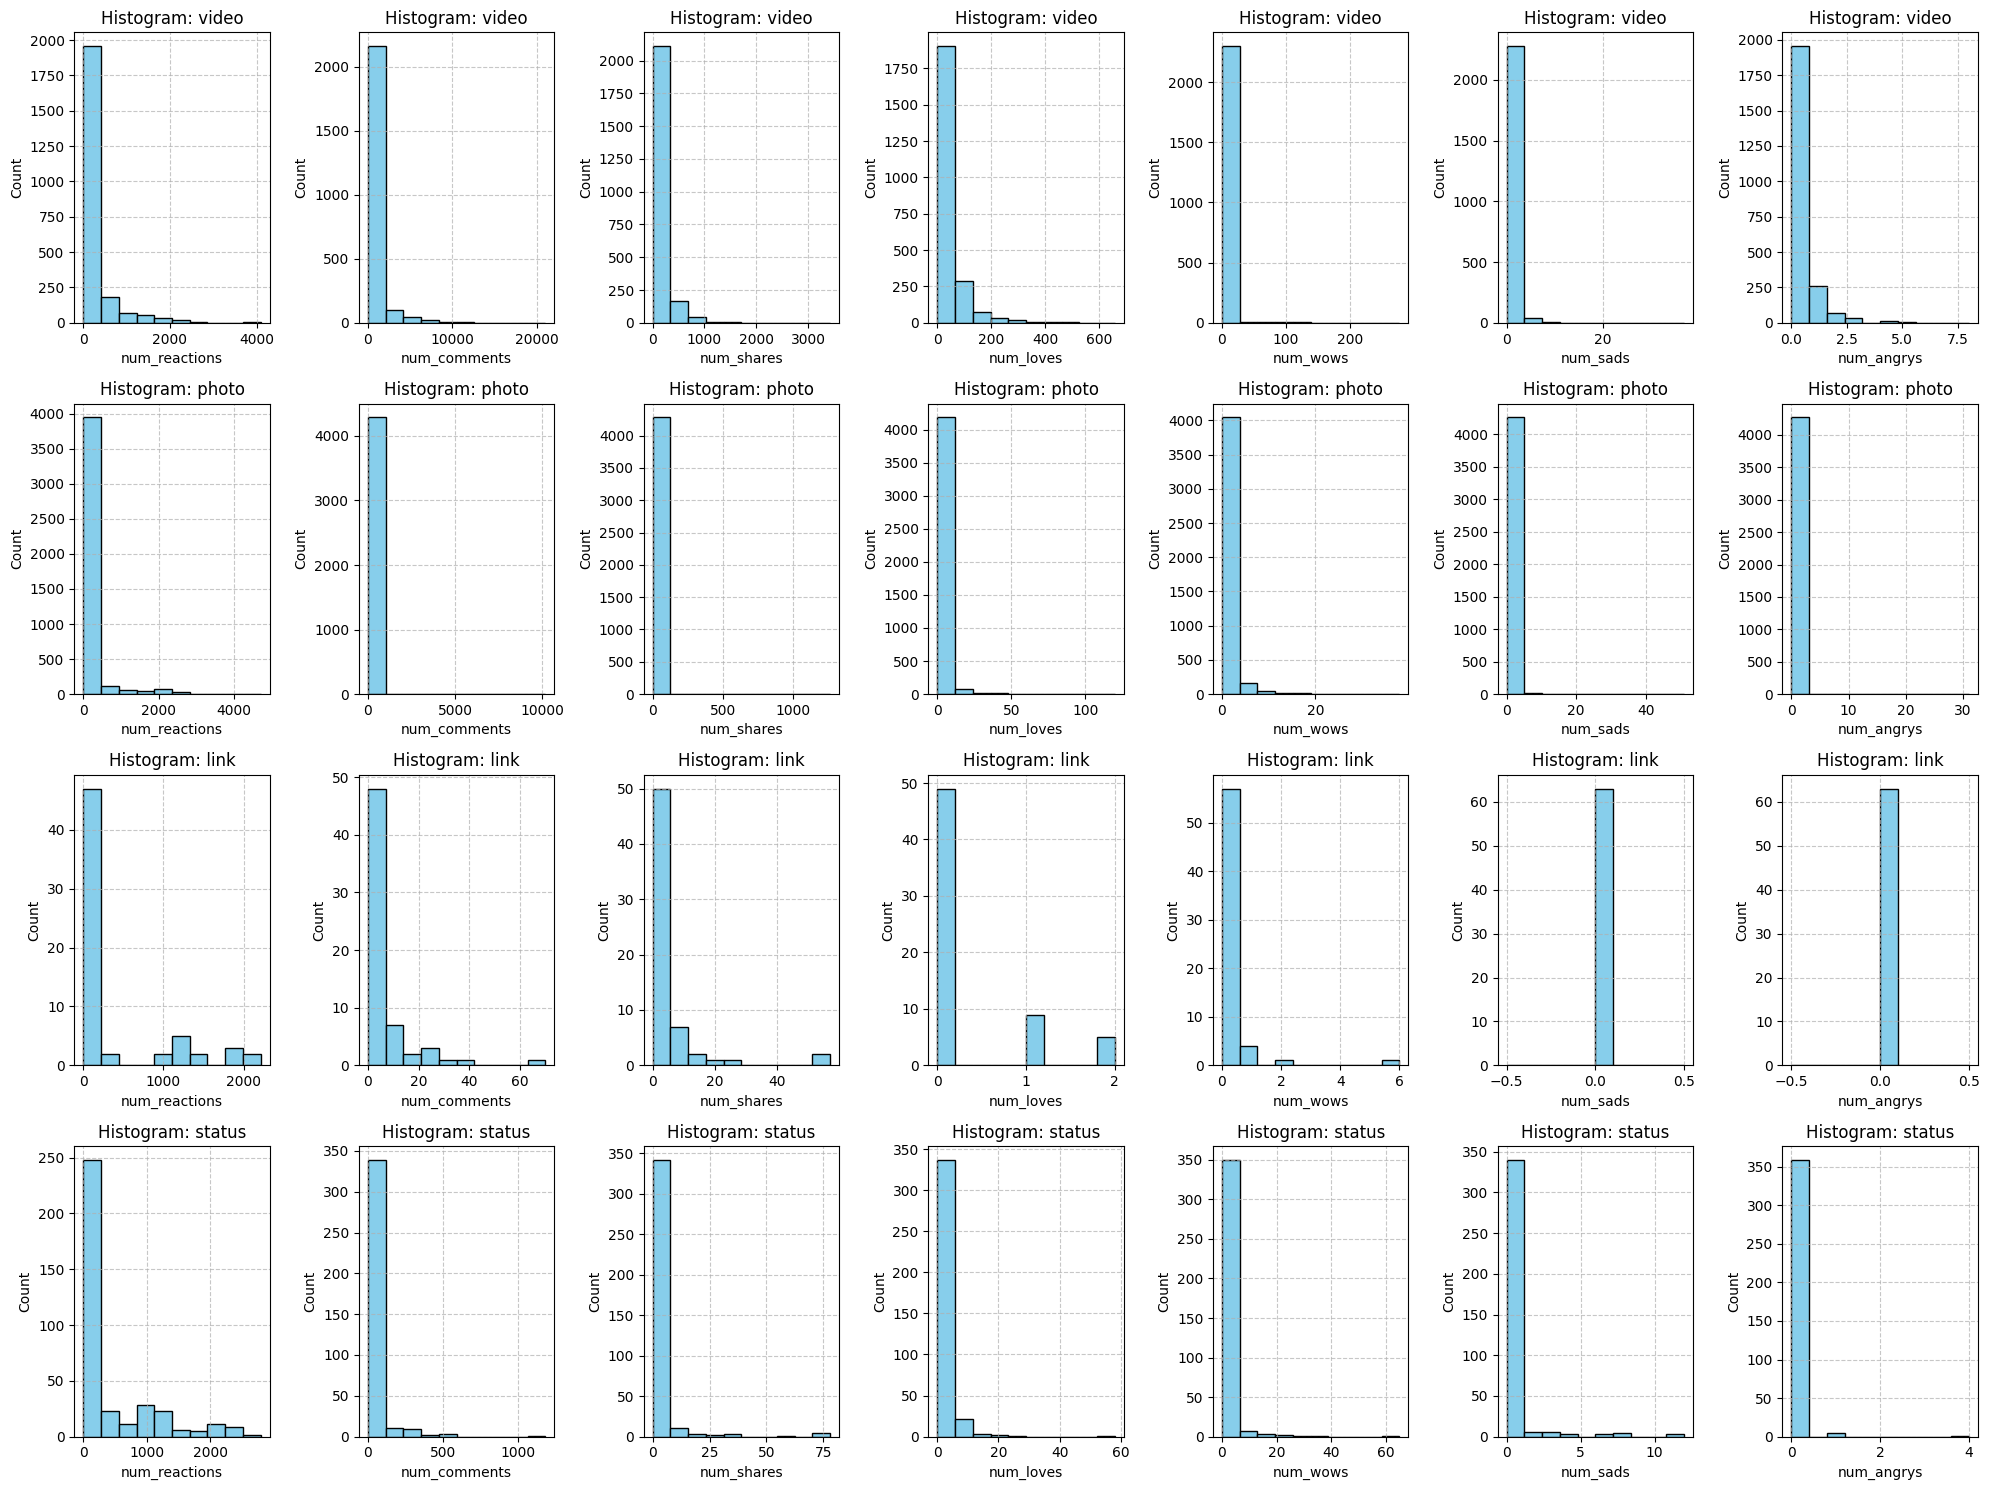

In [157]:
fig, axs = plt.subplots(len(s_type), len(features), figsize=(20, 15))

for i, k in enumerate(s_type):
    for j, c in enumerate(features):
        s = s_type[k]
        
        axs[i][j].hist(df_train.loc[df_train["s_type"] == s][c], color='skyblue', edgecolor='black', bins=10)
        axs[i][j].set_title(f"Histogram: {k}")
        axs[i][j].set_xlabel(c)
        axs[i][j].set_ylabel('Count')
        axs[i][j].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.plot()

After of analyze the histogram per each post type and social media interaction We can observe that all the variables have a similar behavior when the geater number of the records have the less number of interactions.

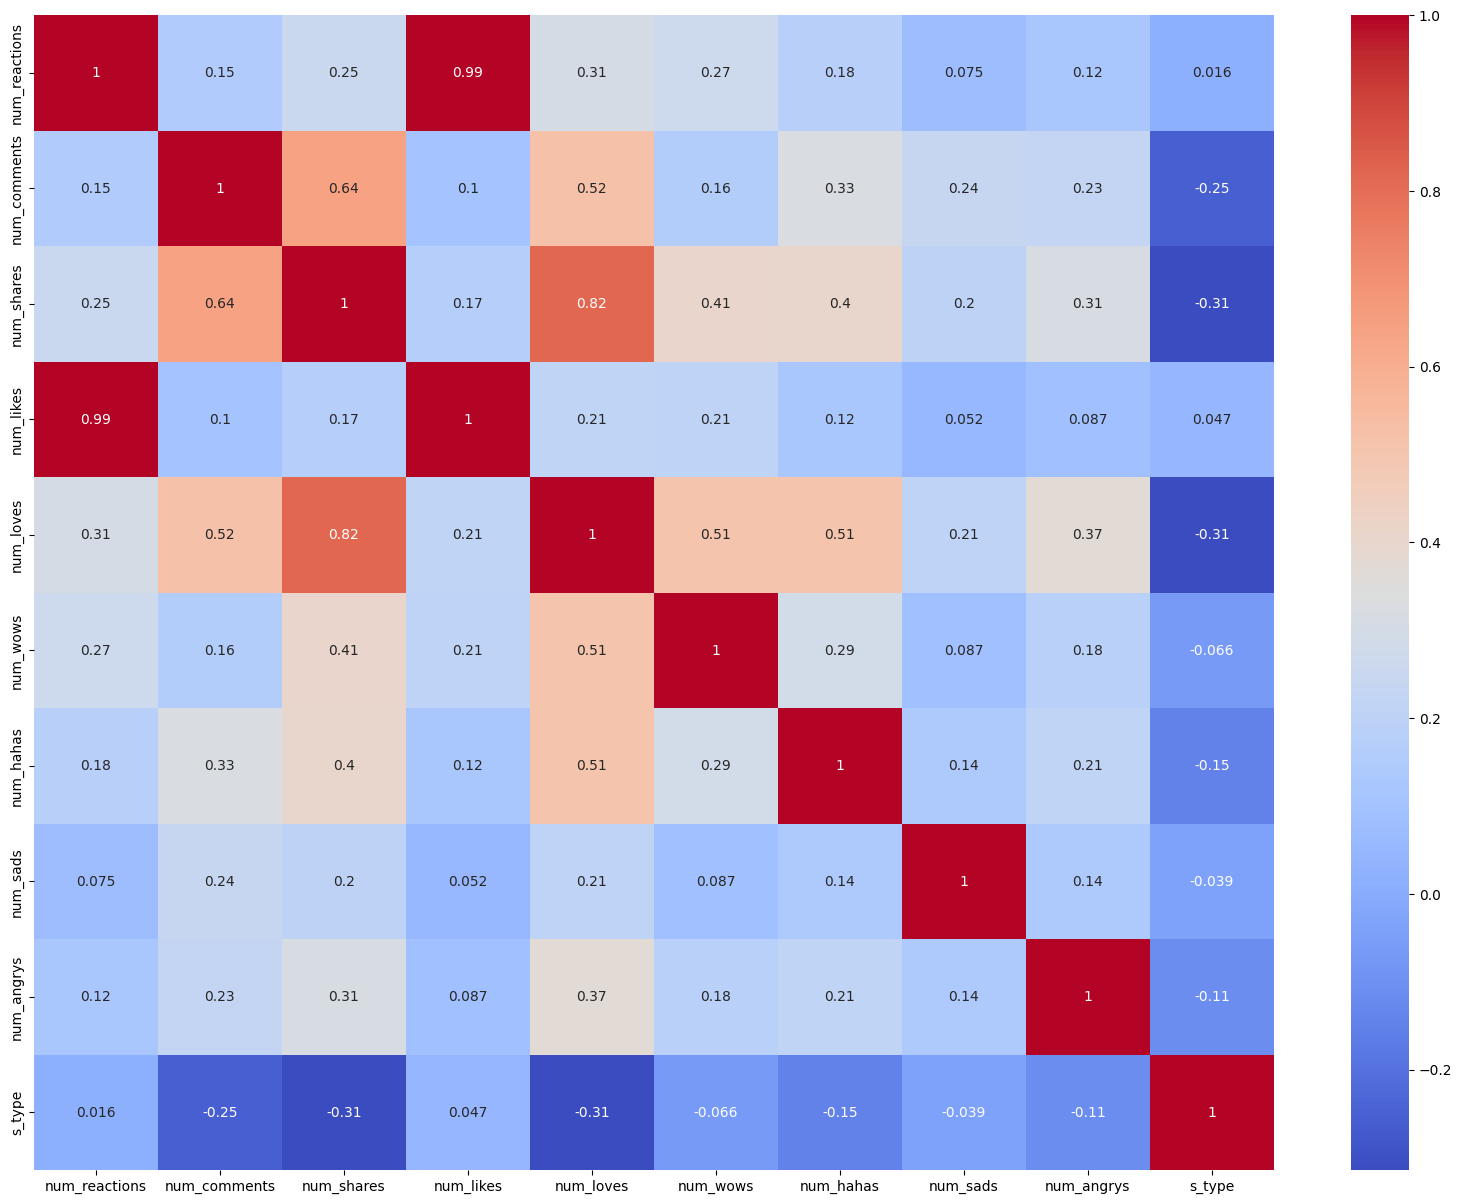

In [160]:
correlation_matrix = df_train.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.show()

The variable that are highly correlated are the number of reaction and the number of likes.

In [161]:
x = df_train.drop(["num_reactions"], axis=1)

### Build and Fit Models

In this section we are going to use the algorithms K-means and Hierarchical to cluster the data. For each algoritm we are going to tuning the hyperparameters. At the of the section we are going to plot the PCA for 2 components for each cluster applied.

#### K-Means

In [184]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(x)
print(f"Inertia: {kmeans.inertia_}")

Inertia: 3489136506.406331


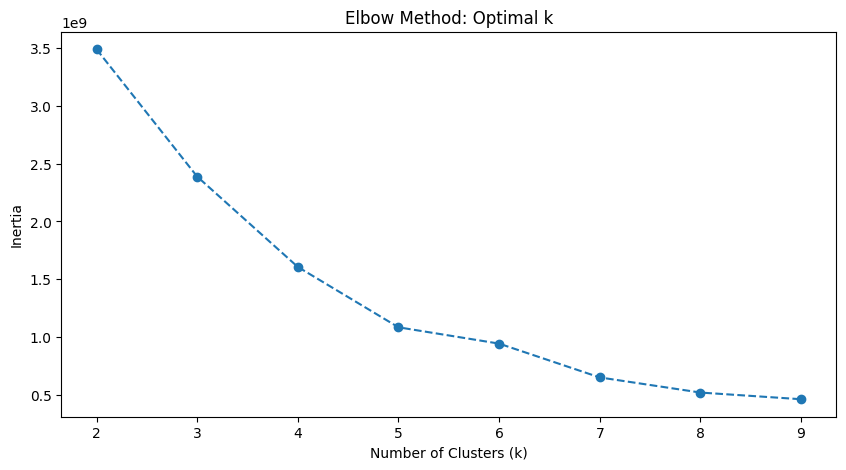

In [191]:
inertia = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_) 

plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Method: Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [218]:
best_k = 7
best_kmeans = KMeans(n_clusters=best_k, random_state=42).fit(x)
kmeans_pred_labels_df = pd.DataFrame(best_kmeans.labels_, columns=['kmeans_pred'])

df_train = pd.concat([df_train, kmeans_pred_labels_df], axis=1)

df_train.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,s_type,hierarchical_pred,kmeans_pred
0,529,512,262,432,92,3,1,1,0,1,0,0
1,150,0,0,150,0,0,0,0,0,2,0,0
2,227,236,57,204,21,1,1,0,0,1,0,0
3,111,0,0,111,0,0,0,0,0,2,0,0
4,213,0,0,204,9,0,0,0,0,2,0,0


#### Hierarchical Clustering 

In [180]:
model = AgglomerativeClustering(n_clusters=5, linkage='average').fit(x)
labels = model.fit_predict(x)
print(model.labels_)
score = silhouette_score(x, labels)
print(score)

[3 3 3 ... 3 3 3]
0.8482458889572471


In [249]:
n_clusters = range(2, 10)
linkages = ['ward', 'complete', 'average', 'single']
affinities = ['euclidean', 'manhattan', 'cosine']

best_score = -1
best_params = {}

for n in n_clusters:
    for linkage in linkages:
        for affinity in affinities:
            if linkage == 'ward' and affinity != 'euclidean': 
                continue
            try:
                model = AgglomerativeClustering(
                    n_clusters=n,
                    linkage=linkage,
                    metric=affinity
                )
                labels = model.fit_predict(x)
                score = silhouette_score(x, labels)
                if score > best_score:
                    print(f'best_score {score}')
                    best_score = score
                    best_params = {
                        'n_clusters': n,
                        'linkage': linkage,
                        'affinity': affinity
                    }
            except Exception as e:
                continue

print("Best Silhouette Score:", best_score)
print("Best Parameters:", best_params)


best_score 0.8879423057255076
best_score 0.9631286432527617
Best Silhouette Score: 0.9631286432527617
Best Parameters: {'n_clusters': 2, 'linkage': 'complete', 'affinity': 'euclidean'}


In [250]:
best_hierarchical = AgglomerativeClustering(
    n_clusters=best_params['n_clusters'],
    linkage=best_params['linkage'],
    metric=best_params['affinity']
).fit(x)

hierarchical_pred_labels_df = pd.DataFrame(best_hierarchical.labels_, columns=['hierarchical_pred'])

df_train = pd.concat([df_train, hierarchical_pred_labels_df], axis=1)

df_train.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,s_type,kmeans_pred,hierarchical_pred
0,529,512,262,432,92,3,1,1,0,1,0,0
1,150,0,0,150,0,0,0,0,0,2,0,0
2,227,236,57,204,21,1,1,0,0,1,0,0
3,111,0,0,111,0,0,0,0,0,2,0,0
4,213,0,0,204,9,0,0,0,0,2,0,0


#### PCA

In [251]:
x_scaled = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_scaled)
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

Explained variance ratio: [0.3704693  0.12593931]


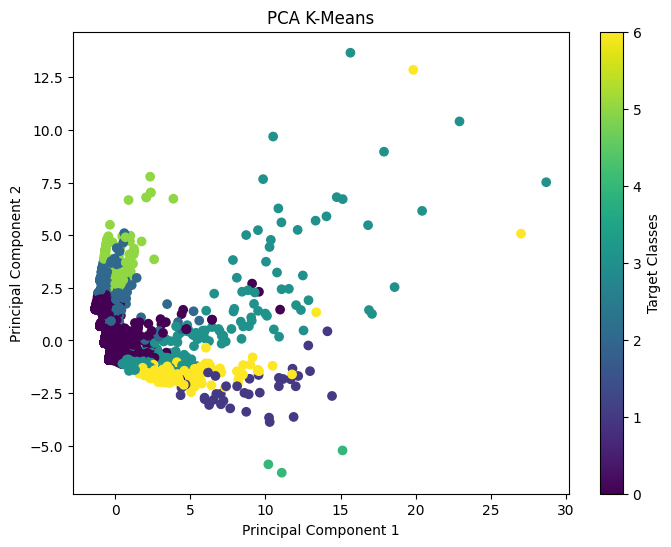

In [252]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_train["kmeans_pred"], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA K-Means')
plt.colorbar(label='Target Classes')
plt.show()

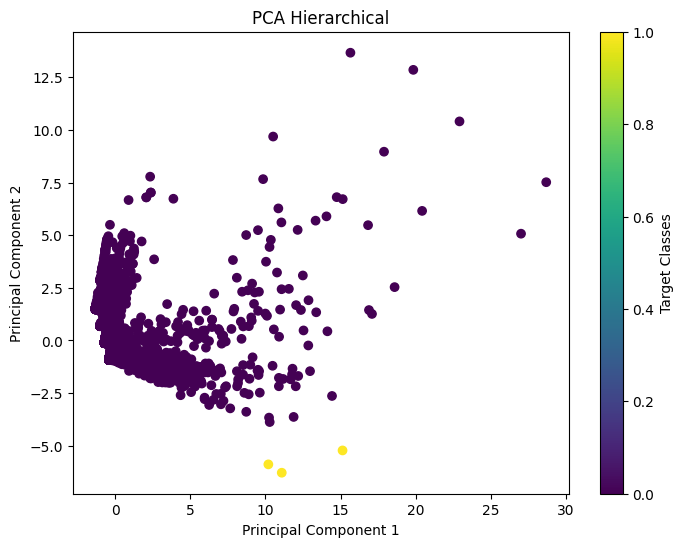

In [253]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_train["hierarchical_pred"], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Hierarchical')
plt.colorbar(label='Target Classes')
plt.show()

### Conclutions

- After applied K-Means tuning and analyze the Elbow chart we can conclude that the best number of clusters is 7.
- In Hierarchical Clustering the best number of clusters calculated by the search method is 2.
- PCA component analysis is only reflecting the 50% of the information using the first two principal components.
- Base on the 2 dimensional analysis of the clusters using the first two principal component We can conclude that K-Means method has the better performance. Each cluster an appropiated number of elements and they are not overlaped in the chart.